# 🏭 Entrenamiento Completo - CSTR (CTRL + ORCH)

**Pipeline completo**:
1. **Fase 1**: Entrenar agente CTRL para controlar Tc y F del CSTR
2. **Fase 2**: Entrenar agente ORCH para optimizar Cb usando el CTRL entrenado

---

## 1️⃣ Imports y Setup

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Agregar path del proyecto si es necesario
sys.path.append('../')

from Environment.Simulation_Env.Reactor_CSTR import CSTRSimulator
from Environment.PIDControlEnv_simple import PIDControlEnv_Simple
from Environment.PIDControlEnv_complex import PIDControlEnv_Complex
from Agente.DQN.train_DQN import DQNTrainer
from Aux.Plots import SimplePlotter, print_summary

print(" Imports completados")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

 Imports completados
PyTorch version: 2.2.2
Device disponible: CPU


---
# 🎯 FASE 1: Entrenar Agente CTRL

**Objetivo**: Entrenar un agente que ajuste parámetros PID para controlar Tc y F.

**Variables**:
- **Manipulables**: Tc (290-450 K), F (99-105 m³/s)
- **Setpoints**: Valores aleatorios dentro de los rangos
- **Agente**: Aprende a ajustar (Kp, Ki, Kd) para cada variable

## 2️⃣ Configuración CTRL

In [2]:
config_ctrl = {
    # ============ AMBIENTE ============
    'env_config': {
        'architecture': 'simple',
        'env_type': 'simulation',
        
        # 2 variables manipulables (Tc, F)
        'n_manipulable_vars': 2,
        'manipulable_ranges': [
            (290, 450),  # Tc [K]
            (99, 105)    # F [m³/s]
        ],
        
        # Los setpoints se generan aleatoriamente
        'manipulable_setpoints': None,  # Random
        
        'dt_usuario': 1.0,
        'max_steps': 100,
        
        'agent_controller_config': {
            'agent_type': 'discrete'
        },
        
        # Simulador CSTR
        'env_type_config': {
            'dt': 1.0,
            'control_limits': ((290, 450), (99, 105))
        },
        
        # Pesos de recompensa
        'reward_weights': {
            'error': 1.0,
            'tiempo': 0.001,
            'overshoot': 0.3,
            'energy': 0.001
        },
        'reward_dead_band': 0.02,
        
        # Límites PID
        'pid_limits': [
            (0.01, 50.0),
            (0.0, 5.0),
            (0.0, 5.0)
        ],
        'delta_percent_ctrl': 0.2,
    },
    
    # ============ AGENTE CTRL ============
    'agent_ctrl_config': {
        'state_dim': 10,   # 5 obs × 2 variables
        'action_dim': 7,
        'n_vars': 2,
        'hidden_dims': (128, 64),
        'lr': 0.0001,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay': 0.998,
        'batch_size': 64,
        'target_update_freq': 100,
        'buffer_type': 'simple',
        'buffer_size': 10000,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'seed': 42
    },
    
    # ============ ENTRENAMIENTO ============
    'n_episodes': 30,
    'max_steps_per_episode': 100,
    'eval_frequency': 50,
    'save_frequency': 9999,
    'log_frequency': 10,
    'checkpoint_dir': 'checkpoints/cstr_ctrl',
}

print("Configuración CTRL creada")
print(f"  Episodios: {config_ctrl['n_episodes']}")
print(f"  Device: {config_ctrl['agent_ctrl_config']['device']}")

Configuración CTRL creada
  Episodios: 30
  Device: cpu


## 3️⃣ Test Ambiente Simple

In [3]:
# Test ambiente
test_env = PIDControlEnv_Simple(config_ctrl['env_config'])
sim_cfg = config_ctrl['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
test_env.proceso.connect_external_process(simulator)
print('CSTR conectado al ambiente simple')

# Reset y step de prueba
obs, info = test_env.reset()
print(f"\nObservación shape: {obs.shape}")
print(f"  PVs iniciales: {test_env.manipulable_pvs}")
print(f"  Setpoints: {test_env.manipulable_setpoints}")

# Step aleatorio
action = test_env.action_space.sample()
obs, reward, done, truncated, info = test_env.step(action)
print(f"\nStep de prueba exitoso")
print(f"  Reward: {reward:.2f}")

CSTR conectado al ambiente simple

Observación shape: (10,)
  PVs iniciales: [78.73579191775971, 70.89396473607215]
  Setpoints: [436.0186033646471, 104.72066987312077]

Step de prueba exitoso
  Reward: -344.51


## 4️⃣ Entrenar CTRL

In [4]:
# Crear trainer CTRL
trainer_ctrl = DQNTrainer(config_ctrl)

# Conectar CSTR
sim_cfg = config_ctrl['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
trainer_ctrl.env.proceso.connect_external_process(simulator)
print('CSTR conectado al trainer CTRL')

print("\nEntrenando agente CTRL...\n")
trainer_ctrl.train()
print("\nEntrenamiento CTRL completado")

CSTR conectado al trainer CTRL

Entrenando agente CTRL...


Episodio 0/30
  Reward: -206.75
  Length: 1
  CTRL Loss: 0.0000
  CTRL Epsilon: 1.0000

Episodio 10/30
  Reward: -323.97
  Length: 1
  CTRL Loss: 0.0000
  CTRL Epsilon: 1.0000

Episodio 20/30
  Reward: -340.23
  Length: 1
  CTRL Loss: 0.0000
  CTRL Epsilon: 1.0000

Entrenamiento CTRL completado


## 5️⃣ Visualizar Resultados CTRL


RESULTADOS CTRL
RESUMEN DE ENTRENAMIENTO

Métrica                        Último       Promedio     Mejor       
Reward                             -321.15     -275.64     -206.75
Energy                         28760640.20 24717175.69 15128508.33
Max Overshoot (%)                     0.00        0.02        0.00

 Mejor episodio: #0 (Reward: -206.75)
Mejora total: -55.3%
Total episodios: 30


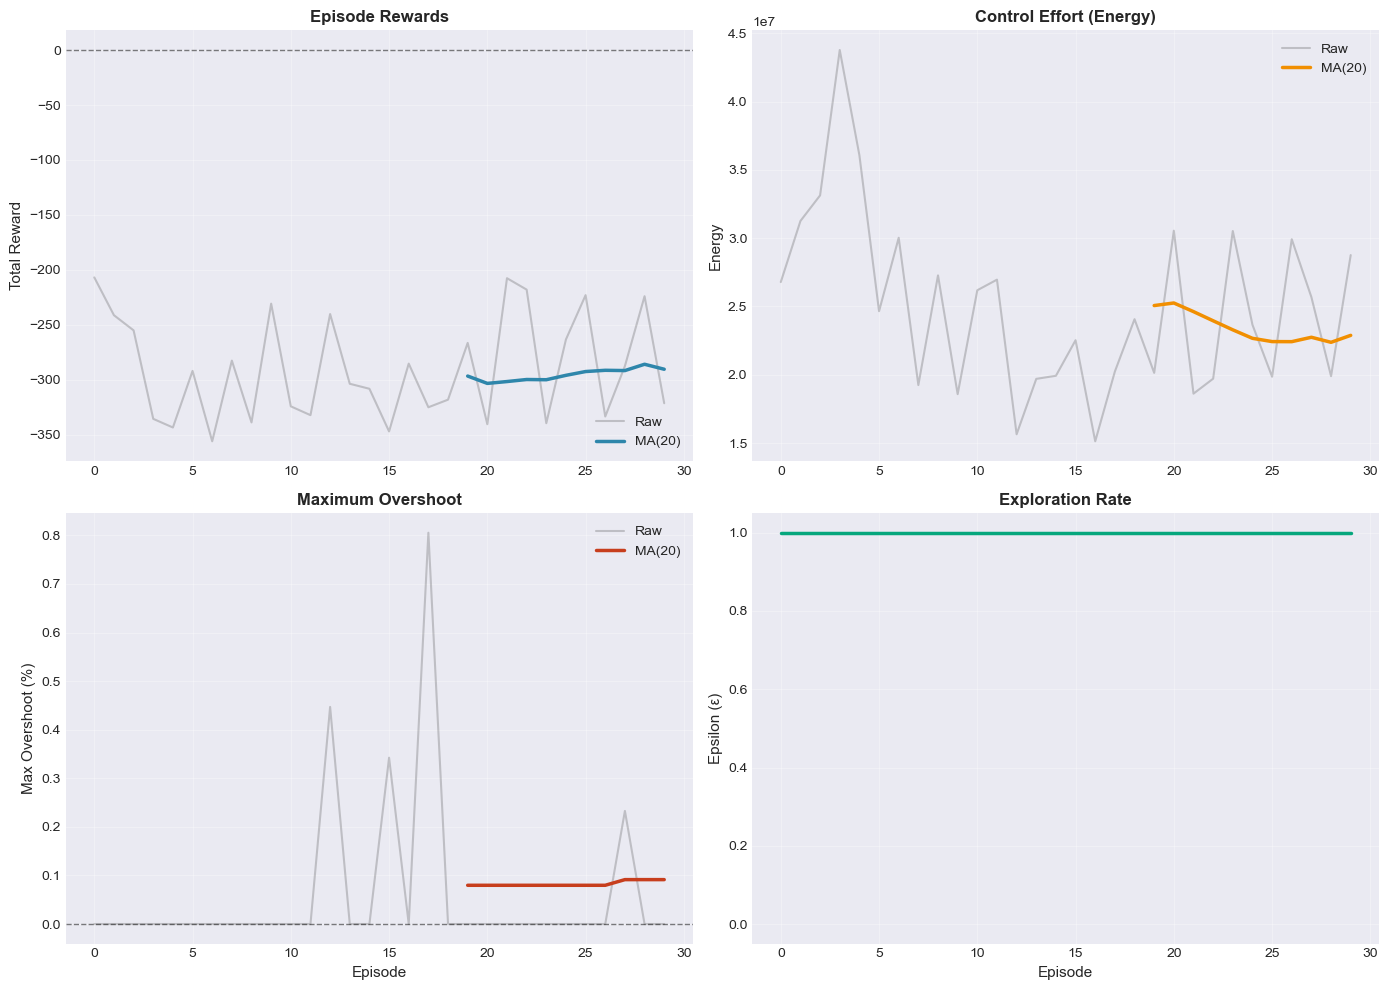

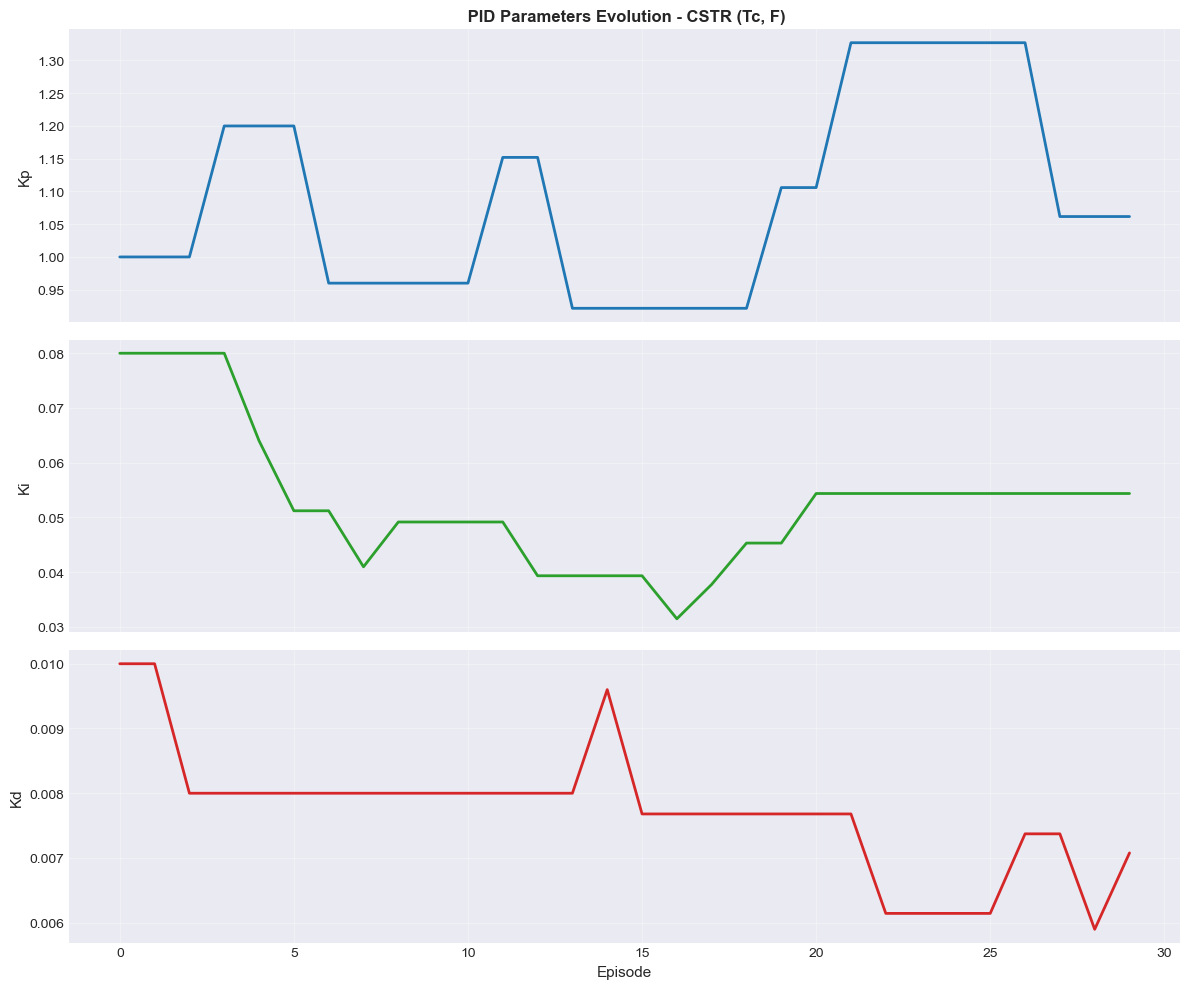

In [5]:
plotter = SimplePlotter()

# Resumen
print("\n" + "="*70)
print("RESULTADOS CTRL")
print_summary(
    episode_rewards=trainer_ctrl.episode_rewards,
    episode_energies=trainer_ctrl.episode_energies,
    episode_max_overshoots=trainer_ctrl.episode_max_overshoots,
    best_episode_idx=np.argmax(trainer_ctrl.episode_rewards)
)
print("="*70)

# Gráficos
plotter.plot_training_overview(
    episode_rewards=trainer_ctrl.episode_rewards,
    episode_energies=trainer_ctrl.episode_energies,
    episode_max_overshoots=trainer_ctrl.episode_max_overshoots,
    epsilons=trainer_ctrl.epsilons,
    window=20
)

# Evolución de PIDs
plotter.plot_pid_evolution(
    kp_history=trainer_ctrl.kp_history,
    ki_history=trainer_ctrl.ki_history,
    kd_history=trainer_ctrl.kd_history,
    var_name="CSTR (Tc, F)"
)

## 6️⃣ Guardar Checkpoint CTRL

In [6]:
# Guardar modelo CTRL
checkpoint_dir = Path(config_ctrl['checkpoint_dir'])
checkpoint_dir.mkdir(exist_ok=True, parents=True)

ctrl_checkpoint_path = checkpoint_dir / 'agent_ctrl_best.pt'
trainer_ctrl.agent_ctrl.save(str(ctrl_checkpoint_path))

print(f" Agente CTRL guardado en: {ctrl_checkpoint_path}")
print(f"\n Este checkpoint se usará para entrenar ORCH")

Agente guardado en: checkpoints/cstr_ctrl/agent_ctrl_best.pt
 Agente CTRL guardado en: checkpoints/cstr_ctrl/agent_ctrl_best.pt

 Este checkpoint se usará para entrenar ORCH


---
# 🎯 FASE 2: Entrenar Agente ORCH

**Objetivo**: Entrenar un agente orquestador que optimice la concentración Cb del reactor.

**Arquitectura**:
- **ORCH**: Observa Cb, decide setpoints para Tc y F
- **CTRL** (pre-entrenado): Ajusta PIDs para alcanzar esos setpoints
- **CSTR**: Procesa Tc y F → genera Cb

## 7️⃣ Configuración ORCH

In [7]:
config_orch = {
    # ============ AMBIENTE ============
    'env_config': {
        'architecture': 'jerarquica',
        'env_type': 'simulation',
        
        # Variables manipulables (controladas por CTRL)
        'n_manipulable_vars': 2,
        'manipulable_ranges': [
            (290, 450),  # Tc [K]
            (99, 105)    # F [m³/s]
        ],
        
        # Variable objetivo (optimizada por ORCH)
        'n_target_vars': 1,
        'target_ranges': [(0.0, 1.0)],           # Cb deseado
        'target_setpoints': [0.4],               # Objetivo: 0.4 mol/m³
        'target_working_ranges': [(0.0, 2.0)],   # Rango físico
        
        'dt_usuario': 1.0,
        'max_steps': 50,
        
        'agent_orchestrator_config': {
            'agent_type': 'discrete'
        },
        
        'env_type_config': {
            'dt': 1.0,
            'control_limits': ((290, 450), (99, 105))
        },
        
        'reward_weights': {
            'error': 2.0,
            'tiempo': 0.01,
            'overshoot': 0.5,
            'energy': 0.1
        },
        'reward_dead_band': 0.02,
        
        'pid_limits': [
            (0.01, 50.0),
            (0.0, 5.0),
            (0.0, 5.0)
        ],
        'delta_percent_ctrl': 0.2,
        'delta_percent_orch': 0.05,
    },
    
    # ============ AGENTE CTRL (Pre-entrenado) ============
    'ctrl_checkpoint_path': str(ctrl_checkpoint_path),  # Usa el checkpoint recién guardado
    'agent_ctrl_config': {
        'state_dim': 10,
        'action_dim': 7,
        'n_vars': 2,
        'action_type': 'discrete',
        'hidden_dims': (128, 64),
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    },
    
    # ============ AGENTE ORCH (A entrenar) ============
    'agent_orch_config': {
        'state_dim': 5,
        'action_dim': 3,
        'n_vars': 1,
        'hidden_dims': (64, 32),
        'lr': 0.001,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay': 0.995,
        'batch_size': 32,
        'target_update_freq': 100,
        'buffer_type': 'simple',
        'buffer_size': 10000,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'seed': 42
    },
    
    # ============ ENTRENAMIENTO ============
    'n_episodes': 500,
    'max_steps_per_episode': 50,
    'eval_frequency': 50,
    'save_frequency': 9999,
    'log_frequency': 10,
    'checkpoint_dir': 'checkpoints/cstr_orch',
}

print(" Configuración ORCH creada")
print(f"  Checkpoint CTRL: {config_orch['ctrl_checkpoint_path']}")
print(f"  Episodios: {config_orch['n_episodes']}")

 Configuración ORCH creada
  Checkpoint CTRL: checkpoints/cstr_ctrl/agent_ctrl_best.pt
  Episodios: 500


## 8️⃣ Test Ambiente Complejo

In [8]:
# Test ambiente
test_env_orch = PIDControlEnv_Complex(config_orch['env_config'])
sim_cfg = config_orch['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
test_env_orch.proceso.connect_external_process(simulator)
print('✅ CSTR conectado al ambiente complejo')

obs, info = test_env_orch.reset()
print(f"\n📊 Observación:")
print(f"  ORCH obs shape: {obs['orch'].shape}")
print(f"  CTRL obs shape: {obs['ctrl'].shape}")
print(f"  Cb actual: {info['target_pvs'][0]:.4f} mol/m³")
print(f"  Cb objetivo: 0.4 mol/m³")

✅ CSTR conectado al ambiente complejo

📊 Observación:
  ORCH obs shape: (5,)
  CTRL obs shape: (10,)
  Cb actual: 0.7370 mol/m³
  Cb objetivo: 0.4 mol/m³


## 9️⃣ Entrenar ORCH

In [9]:
# Crear trainer ORCH
trainer_orch = DQNTrainer(config_orch)

# Conectar CSTR
sim_cfg = config_orch['env_config']['env_type_config']
simulator = CSTRSimulator(**sim_cfg)
trainer_orch.env.proceso.connect_external_process(simulator)
print(' CSTR conectado al trainer ORCH')

print("\n Entrenando agente ORCH...\n")
trainer_orch.train()
print("\nEntrenamiento ORCH completado")

Cargando agente CTRL pre-entrenado desde: checkpoints/cstr_ctrl/agent_ctrl_best.pt


AttributeError: 'DQNTrainer' object has no attribute 'agent_role'

## 🔟 Visualizar Resultados ORCH

In [ ]:
# Resumen
print("\n" + "="*70)
print(" RESULTADOS ORCH")
print_summary(
    episode_rewards=trainer_orch.episode_rewards,
    episode_energies=trainer_orch.episode_energies,
    episode_max_overshoots=trainer_orch.episode_max_overshoots,
    best_episode_idx=np.argmax(trainer_orch.episode_rewards)
)
print("="*70)

# Gráficos
plotter.plot_training_overview(
    episode_rewards=trainer_orch.episode_rewards,
    episode_energies=trainer_orch.episode_energies,
    episode_max_overshoots=trainer_orch.episode_max_overshoots,
    epsilons=trainer_orch.epsilons,
    window=20
)

## 1️⃣1️⃣ Evaluación - Sistema Completo en Acción

In [ ]:
# Modo evaluación
trainer_orch.agent_orch.epsilon = 0.0

# Reset
obs, info = trainer_orch.env.reset()
print(f" Condiciones iniciales:")
print(f"  Cb: {info['target_pvs'][0]:.4f} mol/m³ (objetivo: 0.4)")
print(f"  Tc: {info['manipulable_pvs'][0]:.2f} K")
print(f"  F: {info['manipulable_pvs'][1]:.2f} m³/s")

# Ejecutar episodio
cb_traj = [info['target_pvs'][0]]
tc_traj = [info['manipulable_pvs'][0]]
f_traj = [info['manipulable_pvs'][1]]
rewards_traj = []

done = False
step = 0
max_steps = 50

print(f"\n Ejecutando episodio...")
print(f"{'Step':<6} {'Cb':<10} {'Tc':<10} {'F':<10} {'Reward':<10}")
print("-" * 50)

while not done and step < max_steps:
    action = trainer_orch.agent_orch.select_action(obs['orch'], training=False)
    obs, reward, terminated, truncated, info = trainer_orch.env.step(action)
    done = terminated or truncated
    
    cb_traj.append(info['target_pvs'][0])
    tc_traj.append(info['manipulable_pvs'][0])
    f_traj.append(info['manipulable_pvs'][1])
    rewards_traj.append(reward)
    
    print(f"{step:<6} {info['target_pvs'][0]:<10.4f} {info['manipulable_pvs'][0]:<10.2f} "
          f"{info['manipulable_pvs'][1]:<10.2f} {reward:<10.2f}")
    
    step += 1

print("-" * 50)
print(f"\n Episodio completado")
print(f"  Cb final: {cb_traj[-1]:.4f} mol/m³")
print(f"  Error final: {abs(cb_traj[-1] - 0.4):.4f}")
print(f"  Reward total: {sum(rewards_traj):.2f}")

## 1️⃣2️⃣ Visualización Final

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
steps = np.arange(len(cb_traj))

# Cb
ax = axes[0]
ax.plot(steps, cb_traj, label='Cb', color='#2E86AB', linewidth=2.5, marker='o', markersize=4)
ax.axhline(y=0.4, label='Objetivo', color='#C73E1D', linestyle='--', linewidth=2)
ax.fill_between(steps, 0.392, 0.408, alpha=0.2, color='#06A77D', label='±2%')
ax.set_ylabel('Cb [mol/m³]', fontsize=12)
ax.set_title('🎯 Concentración de B (Variable Objetivo)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Tc y F
ax = axes[1]
ax.plot(steps, tc_traj, label='Tc', color='#F18F01', linewidth=2, marker='s', markersize=3)
ax.set_ylabel('Tc [K]', fontsize=12, color='#F18F01')
ax.tick_params(axis='y', labelcolor='#F18F01')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(steps, f_traj, label='F', color='#06A77D', linewidth=2, marker='^', markersize=3)
ax2.set_ylabel('F [m³/s]', fontsize=12, color='#06A77D')
ax2.tick_params(axis='y', labelcolor='#06A77D')
ax2.legend(loc='upper right')
ax.set_title('🔧 Variables Manipuladas (Decididas por ORCH → Controladas por CTRL)', 
             fontsize=14, fontweight='bold')

# Rewards
ax = axes[2]
ax.plot(range(len(rewards_traj)), rewards_traj, color='#C73E1D', linewidth=2, marker='o', markersize=4)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Step', fontsize=12)
ax.set_ylabel('Reward', fontsize=12)
ax.set_title('💰 Recompensa', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1️⃣3️⃣ Guardar Modelos Finales

In [ ]:
# Guardar ORCH
orch_dir = Path(config_orch['checkpoint_dir'])
orch_dir.mkdir(exist_ok=True, parents=True)
orch_path = orch_dir / 'agent_orch_final.pt'
trainer_orch.agent_orch.save(str(orch_path))

print(f"Modelos guardados:")
print(f"  CTRL: {ctrl_checkpoint_path}")
print(f"  ORCH: {orch_path}")

---
# 🎉 Entrenamiento Completo Finalizado

## ✅ Lo que se logró:

### **Fase 1 - CTRL**:
- ✅ Entrenaste un agente que controla Tc y F del CSTR
- ✅ Aprende a ajustar parámetros PID para alcanzar setpoints

### **Fase 2 - ORCH**:
- ✅ Entrenaste un agente que optimiza Cb
- ✅ Usa CTRL para manipular Tc y F
- ✅ Aprende qué setpoints dar a CTRL para lograr el objetivo

## 🚀 Próximos pasos:
- Ajustar hiperparámetros si es necesario
- Probar con diferentes objetivos de Cb
- Entrenar por más episodios
- Comparar con PID clásico en cascada